# Семинар 4 - Интерполяция изображений, геометрия формирования изображения и калибровка камеры

***

In [1]:
from pathlib import Path

import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Интерполяция изображений

![](data/interpolation.svg)
Задача - эффективно уменьшить/увеличить изображение.

Рассмотрим несколько методов интерполяции.

## а) Интерполяция по ближайшему пикселю

![](data/inter_nearest.png)

Самая простая и самая быстрая, однако она приводит к сильным артефактам.

## б) Билинейная интерполяция

![](data/inter_linear.png)

Лучше по качеству, но требует больше вычислений и вдобавок размывает границы объектов.

## в) Бикубическая интерполяция

![](data/inter_cubic.png)

Еще лучше в непрерывных областях, но на границе возникает [эффект гало](https://ru.wikipedia.org/wiki/Гало) (более темная полоса вдоль темного края границы и светлая вдоль светлого).

## Примеры

Согласно [документации OpenCV](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html) для **сжатия изображения** — наиболее предпочтительным методом интерполяции является `cv.INTER_AREA`,
**для увеличения изображения** — наиболее предпочтительны методы интерполяции: `cv.INTER_CUBIC` (медленный) и `cv.INTER_LINEAR`.

In [2]:
interpolation_algorithm = [
    ("nearest", cv2.INTER_NEAREST),
    ("bilinear", cv2.INTER_LINEAR),
    ("bicubic", cv2.INTER_CUBIC),
    ("area", cv2.INTER_AREA),
    ("lanczos4", cv2.INTER_LANCZOS4)
]

def resize_by_factor(
    img: np.array,
    factor: float,
) -> None:

    height, width = img.shape[:2]
    height2, width2 = int(height*factor), int(width*factor)

    print(f'orig size: h={height}, w={width}, resised size: h={height2}, w={width2}')

    fig, axes = plt.subplots(
        nrows=len(interpolation_algorithm),
        sharex=True,
        sharey=True,
        figsize=(3, 20)
    )

    imgs = []
    for i in range(len(interpolation_algorithm)):

        img_resized = cv2.resize(
            src=img,
            dsize=(width2, height2),
            interpolation=interpolation_algorithm[i][1],
        )

        axes[i].imshow(img_resized, cmap='Greys_r')
        axes[i].set_title(
            f"{interpolation_algorithm[i][0]}, shape = {img_resized.shape}",
        )

### Оригинальное изображение

Text(0.5, 1.0, 'Original image, shape = (50, 50)')

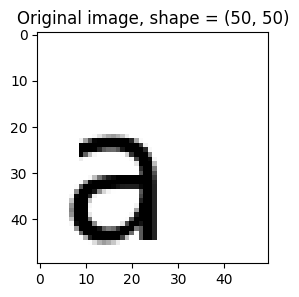

In [3]:
IMG_PATH = "data/a_letter.png"

if not Path(IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_04/data .

a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(3, 3))
plt.imshow(a_letter_img, cmap="Greys_r")
plt.title(f"Original image, shape = {a_letter_img.shape}")

### Увеличение

orig size: h=50, w=50, resised size: h=250, w=250


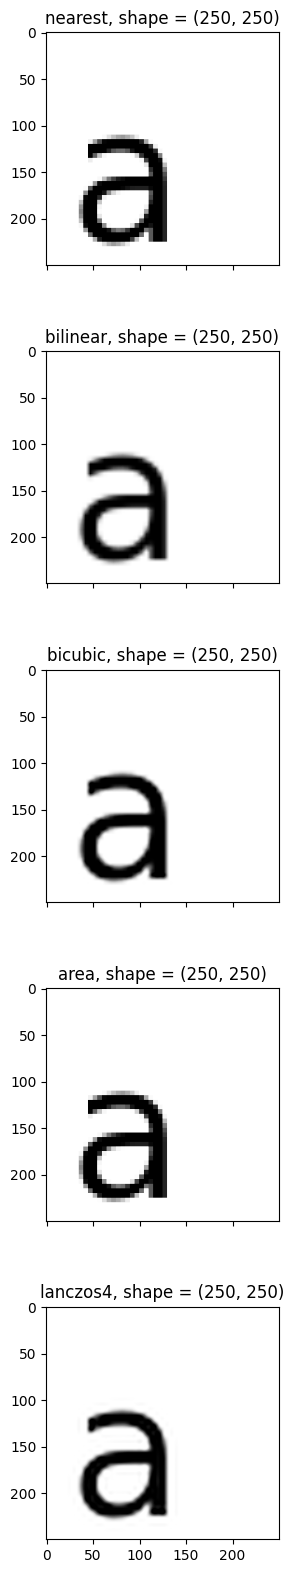

In [4]:
resize_by_factor(
    img=a_letter_img,
    factor=5,
)

### Уменьшение

orig size: h=50, w=50, resised size: h=25, w=25


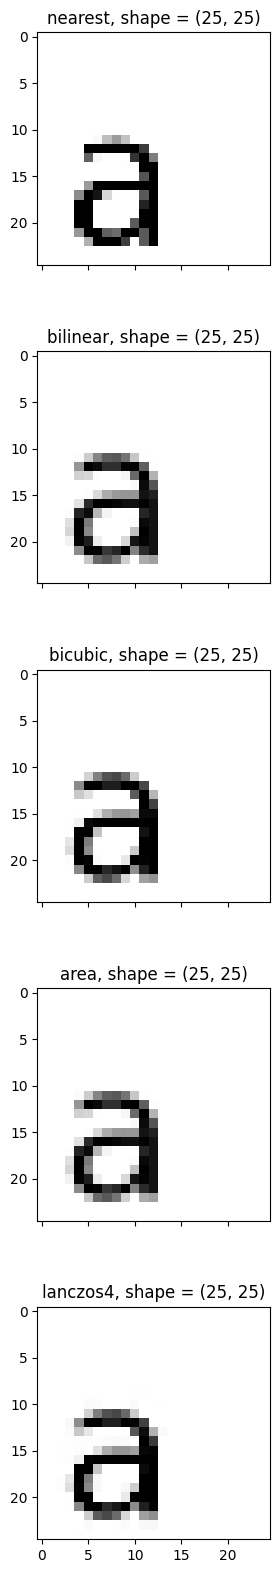

In [5]:
resize_by_factor(
    img=a_letter_img,
    factor=0.5,
)

# Упражение 1

Можно ли реализовать сжатие изображений на свертках? Реализуйте свертку, которая будет уменьшать изображение в 2 раза.

Да, сжатие изображений можно реализовать с использованием сверток. Для уменьшения изображения вдвое с помощью сверток, можно применить операцию свертки с ядром, которое будет вычислять новые значения пикселей на уменьшенном изображении на основе значений пикселей в окрестности каждого пикселя исходного изображения. После этого можно применить дополнительные шаги, такие как отбрасывание каждого второго пикселя, чтобы уменьшить размер изображения.

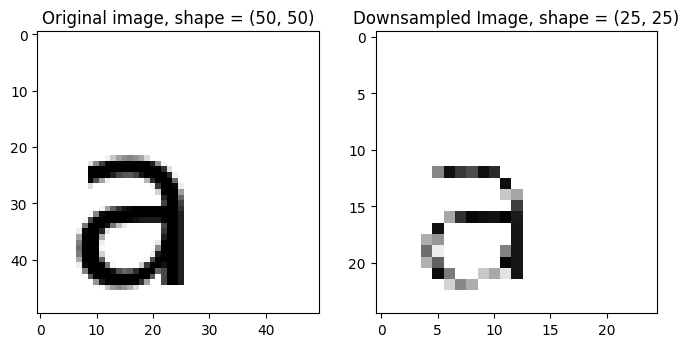

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def bilinear_interpolation(image):
    # Создаем ядро для билинейной интерполяции
    kernel = np.array([[0.25, 0.5, 0.25],
                       [0.5,  1.0, 0.5],
                       [0.25, 0.5, 0.25]], dtype=np.float32)

    # Применяем свертку с ядром билинейной интерполяции
    interpolated_image = cv2.filter2D(image, -1, kernel, borderType=cv2.BORDER_CONSTANT)

    return interpolated_image[::2, ::2]  # Уменьшаем размер изображения вдвое

# Пример использования
IMG_PATH = "data/a_letter.png"

a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
downsampled = bilinear_interpolation(a_letter_img)

# Отображаем
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(a_letter_img, cmap='gray')
plt.title(f"Original image, shape = {a_letter_img.shape}")

plt.subplot(1, 2, 2)
plt.imshow(downsampled, cmap='gray')
plt.title(f'Downsampled Image, shape = {downsampled.shape}')

plt.show()

# Трансформация изображений

[Туториал OpenCV "Geometric Transformations of Images"](https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html)

![](data/image_transformations.png)
_Источник - [Computer Vision: Algorithms and Applications, 2nd ed. 2022 Richard Szeliski](https://szeliski.org/Book/)_

## Поворот (Rotation)

Входные параметры: угол поворота (angle)

```python
matrix = np.array([
      [np.cos(angle),  np.sin(angle), 0],
      [-np.sin(angle), np.cos(angle), 0],
      [0,              0,             1],
])
```

## Растяжение/сжатие (Scale)

Входные параметры: фактор растяжения (tx, ty)

```python
matrix = np.array([
      [t[0], 0,    0],
      [0,    t[1], 0],
      [0,    0,    1],
])
```

## Перенос (translation)

Входные параметры: фактор переноса (tx, ty)

```python
matrix = np.array([
      [1,  0, t[0]],
      [0,  1, t[1]],
      [0,  0,    1],
])
```

## Сдвиг (shearing)

Входные параметры: фактор сдвига (tx, ty)

```python
matrix_horisontal = np.array([
      [1,    t[0], 0],
      [t[1], 1,    0],
      [0,    0,    1],
])
```


# Упражнение 2

Реализуйте функцию, которая принимает изображение и матрицу преобразования, и реализует афинную трансформацию. Не забудьте про центрирование.

Идея - афинное перемещение пикселей изображения.

In [7]:
def affine_transform(
    img: np.array,
    mat: np.array,
) -> np.array:

    # transfromed image
    transfromed_img = np.zeros_like(img)

    # image shape
    H, W = img.shape[:2]

    # center of the img
    cx, cy = (H + 1) // 2 - 1, (W + 1) // 2 - 1

    for x in range(H):
        for y in range(W):

            p = np.dot(mat, np.array([x - cx, y - cy, 1]))

            nx, ny = int(p[0] + cx), int(p[1] + cy)

            if 0 <= nx < H and 0 <= ny < W:
                transfromed_img[nx, ny] = img[x, y]

    return transfromed_img

def make_rotation(
    params,
) -> np.array:

    angle = params[0]

    mat = np.array([
        [np.cos(angle), np.sin(angle), 0],
        [-np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

    return mat

def make_scaling(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
        [tx, 0, 0],
        [0, ty, 0],
        [0, 0, 1]
    ])

    return mat

def make_translation(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
        [1,  0, tx],
        [0,  1, ty],
        [0,  0,  1]
    ])

    return mat

def make_shearing(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
        [1, tx, 0],
        [ty, 1, 0],
        [0,  0,  1]
    ])

    return mat

Проверьте код на примере изображения c астронавтом

In [9]:
import ipywidgets
from skimage import data

img = data.astronaut()

#resize image for much faster affine processing
img = cv2.resize(
    src=img,
    dsize = None,
    fx=0.3,
    fy=0.3,
    interpolation=cv2.INTER_AREA,
)

@ipywidgets.interact(
    tx=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),

    ty=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),
    angle=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),
)
def play_with_params(
    tx: float,
    ty: float,
) -> None:

    angle = tx
    # an example
    mat = make_rotation([angle])

    transformed_img = affine_transform(
        img=img,
        mat=mat
    )

    plt.imshow(transformed_img)

interactive(children=(FloatSlider(value=1.0, description='tx', max=3.14, min=-3.14, step=0.01), FloatSlider(va…

# Вопрос 1

Запустите все 4 преобразования. Изменяйте параметры алгоритма. Имеются ли пиксели, которые никуда не перешли в результате трансформации?

**Ответ:**
При аффинных преобразованиях обычно несколько пикселей остаются на своих местах. Это происходит в случаях, когда пиксели лежат на оси вращения или на каких-то других ключевых точках преобразования.

Например, при повороте изображения относительно его центра некоторые пиксели, находящиеся на оси вращения, не изменяют своего положения. Точки находятся на таком расстоянии от центра изображения, что их координаты после поворота остаются такими же, как и до преобразования.

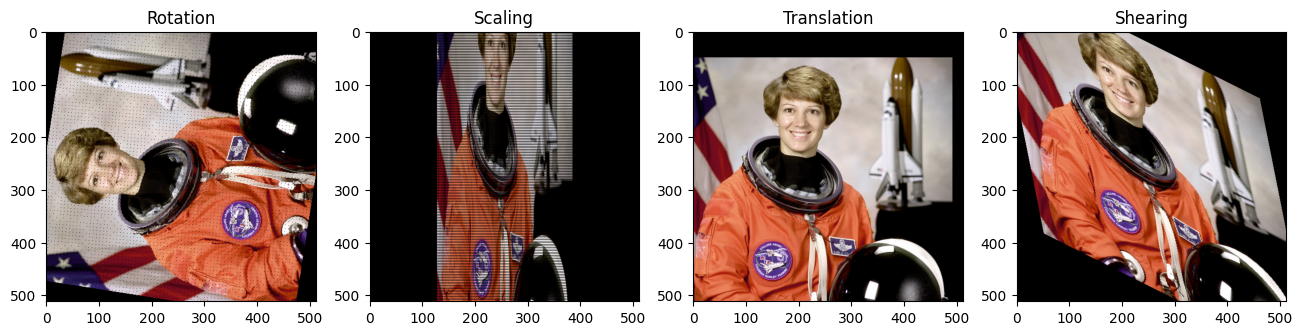

In [23]:
# Загрузка изображения
image =data.astronaut()

# Параметры преобразования
angle = 30
scale_x = 1.5
scale_y = 0.5
tx = 50
ty = -20

# Создание матриц преобразования
rotation_matrix = make_rotation([angle])
scaling_matrix = make_scaling([scale_x, scale_y])
translation_matrix = make_translation([tx, ty])
shearing_matrix = make_shearing([0.5, 0.2])

# Применение аффинных преобразований к изображению
transformed_image_rotation = affine_transform(image, rotation_matrix)
transformed_image_scaling = affine_transform(image, scaling_matrix)
transformed_image_translation = affine_transform(image, translation_matrix)
transformed_image_shearing = affine_transform(image, shearing_matrix)

# Отображение результатов преобразований
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(transformed_image_rotation)
plt.title("Rotation")

plt.subplot(1, 4, 2)
plt.imshow(transformed_image_scaling)
plt.title("Scaling")

plt.subplot(1, 4, 3)
plt.imshow(transformed_image_translation)
plt.title("Translation")

plt.subplot(1, 4, 4)
plt.imshow(transformed_image_shearing)
plt.title("Shearing")

plt.show()

# Формирование изображения

## Внешние параметры камеры

Некоторые камеры-обскуры вносят значительные искажения в изображения. Два основных вида искажений - это радиальные искажения и тангенциальные искажения.

**Радиальные искажения** возникают из-за неидеальности линз и приводит к тому, что прямые линии кажутся изогнутыми.

**Тангенциальные искажения** возникают из-за того, что объектив для съемки изображения не выровнен идеально параллельно плоскости изображения. Таким образом, некоторые области на изображении могут выглядеть ближе, чем ожидалось. 

Виды радиального искажения:
<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Barrel_distortion.svg" alt="drawing" width="200"/>
<figcaption>Barrel distortion (Positive k1 > 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5b/Pincushion_distortion.svg" alt="drawing" width="200"/>
<figcaption>Pincushion distortion (Negative k1 < 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3c/Mustache_distortion.svg" alt="drawing" width="200"/>
<figcaption>Mustache distortion (Complex)</figcaption>
</figure>

Формулы:

$x_{dist} = x\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + 2p_{1}xy + p_{2}(r^{2} + 2x^{2})$

$y_{dist} = y\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy$,

где $r^{2} = x^{2} + y^{2}$

Таким образом, параметры радиальной дисторсии - ($k_{1}, \cdots, k_{6}$), тангенциальной дисторсии - ($p_{1}, p_{2}$)

В дополнение к этому нам нужны внутренние и внешние параметры камеры. Внутренние параметры специфичны для конкретной камеры. Они включают в себя такую информацию, как фокусное расстояние (fx,fy) и оптические центры (cx, cy). Фокусное расстояние и оптические центры могут быть использованы для создания матрицы камеры, которую можно использовать для устранения искажений, вызванных объективами конкретной камеры. Матрица камеры уникальна для конкретной камеры, поэтому после расчета ее можно повторно использовать на других изображениях, сделанных той же камерой.

# Вопрос 2

Запишите выражение связи точек в координатной системе камеры (x, y, z) c проекцией (изображением), зная параметры дисторсии и параметры камеры.

**Ответ:**


Выражение связи точек в координатной системе камеры $(x, y, z)$ с проекцией (изображением) можно записать с использованием уравнения камеры. Предположим, что точка в трехмерном пространстве имеет координаты $(X, Y, Z)$. Эти координаты могут быть преобразованы в координаты изображения $(x, y)$ с использованием уравнения камеры:


\begin{align*}
x &= \left(f_x \cdot \frac{X}{Z}\right) + c_x \\
y &= \left(f_y \cdot \frac{Y}{Z}\right) + c_y \\
\end{align*}


где:

- $x$ и $y$ - координаты точки на изображении,
- $X$, $Y$ и $Z$ - координаты точки в трехмерном пространстве,
- $f_x$ и $f_y$ - фокусные расстояния в направлениях $x$ и $y$ соответственно,
- $c_x$ и $c_y$ - оптические центры изображения в направлениях $x$ и $y$ соответственно.

После этого координаты изображения могут быть скорректированы для учета радиальных и тангенциальных искажений с использованием формул, представленных выше.


# Упражнение 3

Найдите параметры вашей камеры мобильного телефона. 

Используйте шаблон шахматной доски. Можете воспользоваться ресурсом https://markhedleyjones.com/projects/calibration-checkerboard-collection  - здесь можно выбрать необходимый размер и подготовить pdf с доской. Во время печати не забудьте проверить, что масштаб не меняется (часто в параметрах печати по умолчанию установлен флаг "scale to fit page").

Воспользуйтесь [туториалом OpenCV](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

В ответе требуется:

1. Загрузить все сделанные фотографии (туториал рекомендует использовать не менее 10-ти изображений) в папку `./data/calibr_images`. Написанный код должен воспроизводить ваши результаты без дополнительных манипуляций.
2. Вывести найденные параметры калибровки (intrinsic матрицу и параметры дисторсии).
3. Отобразить изображения до и после устранения дисторсии.
4. Посчитать ошибку репроектирования (см. туториал opencv).

Image ./data/calibr_images\photo_1.jpg: 70 углов найдено
Image ./data/calibr_images\photo_10.jpg: 70 углов найдено
Image ./data/calibr_images\photo_11.jpg: 70 углов найдено
Image ./data/calibr_images\photo_12.jpg: 70 углов найдено
Image ./data/calibr_images\photo_2.jpg: 70 углов найдено
Image ./data/calibr_images\photo_3.jpg: 70 углов найдено
Image ./data/calibr_images\photo_4.jpg: 70 углов найдено
Image ./data/calibr_images\photo_5.jpg: 70 углов найдено
Image ./data/calibr_images\photo_6.jpg: 70 углов найдено
Image ./data/calibr_images\photo_7.jpg: 70 углов найдено
Image ./data/calibr_images\photo_8.jpg: 70 углов найдено
Image ./data/calibr_images\photo_9.jpg: 70 углов найдено
Intrinsic matrix:
[[989.24568188   0.         483.86554396]
 [  0.         991.05721949 645.86880931]
 [  0.           0.           1.        ]]
Distortion coefficients:
[[ 2.57291608e-01 -1.52876861e+00 -1.02758598e-03 -6.00826791e-04
   3.09525517e+00]]


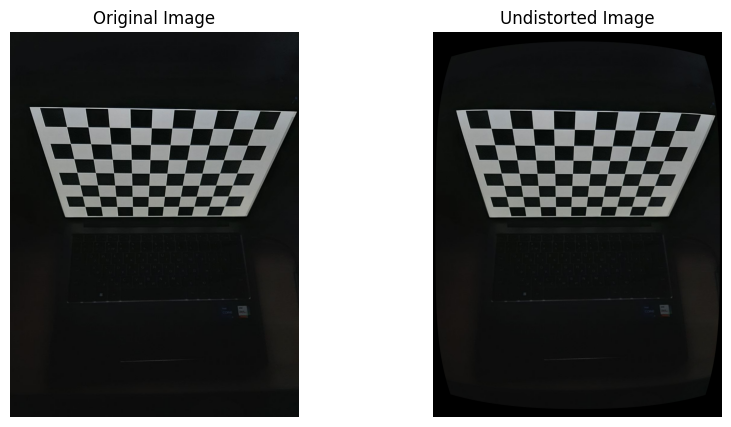

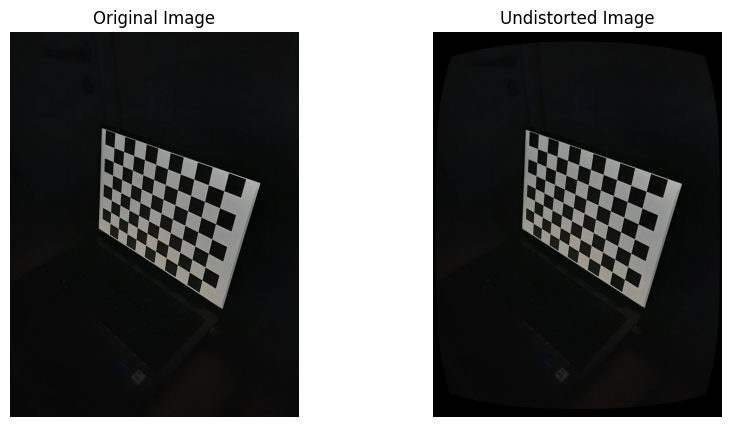

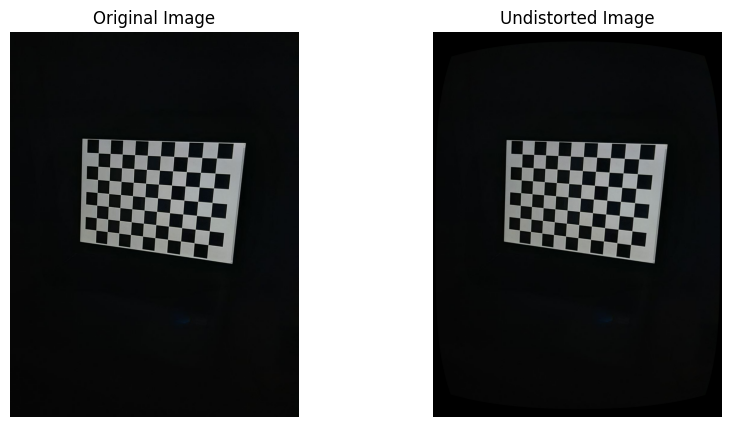

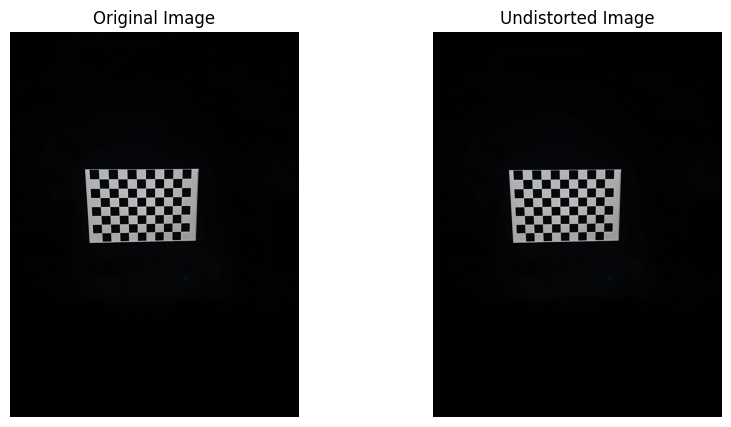

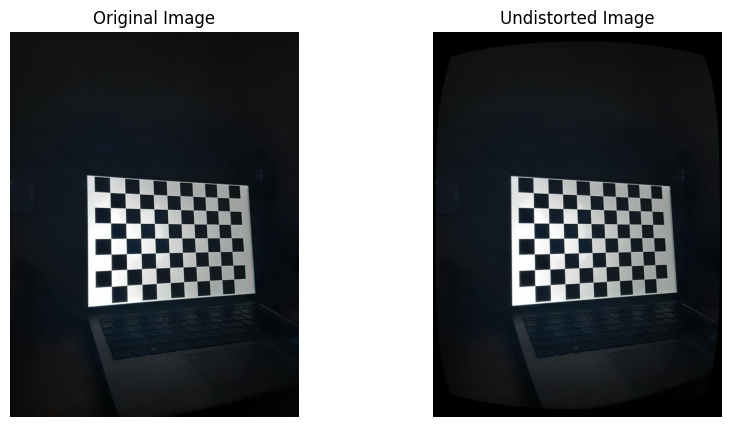

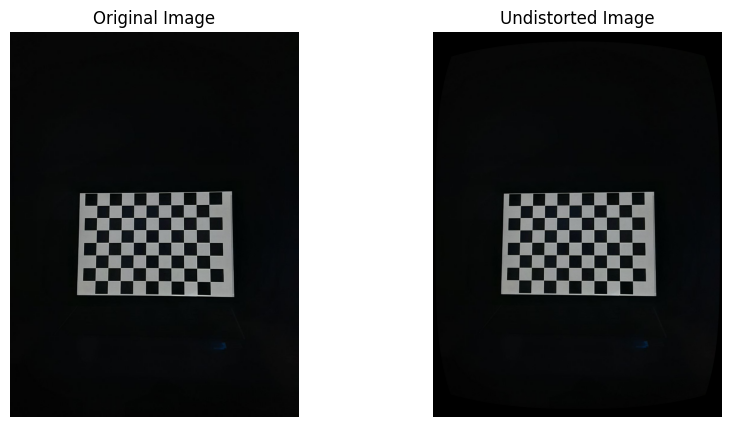

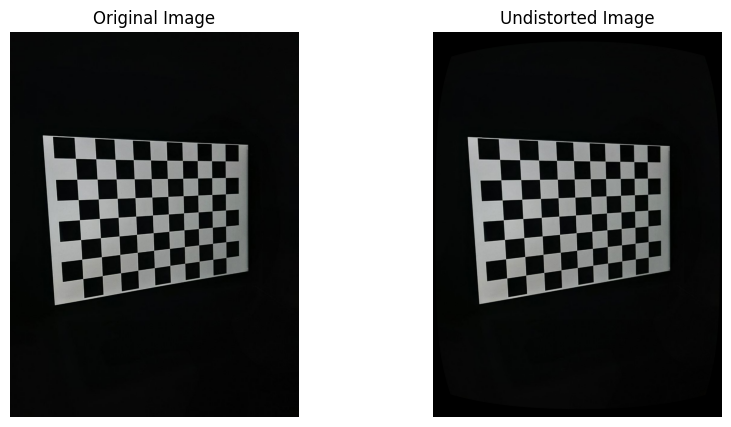

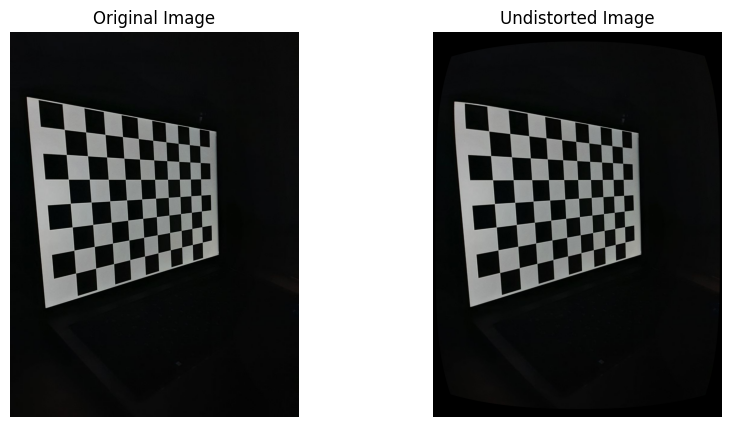

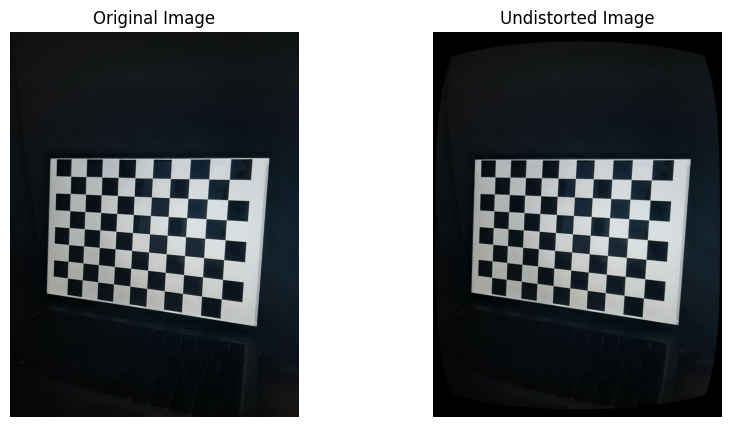

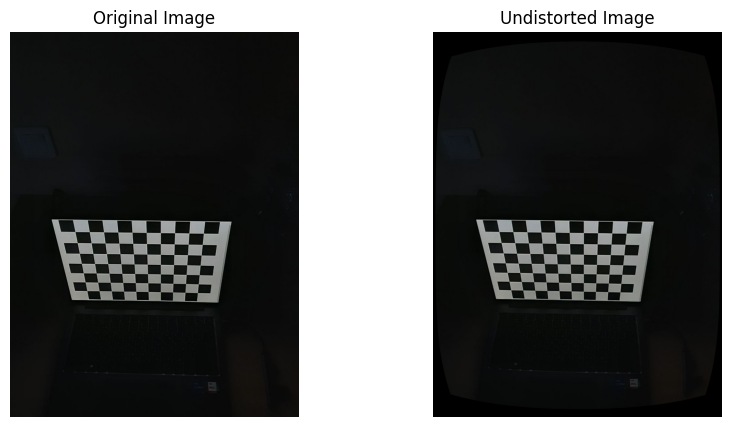

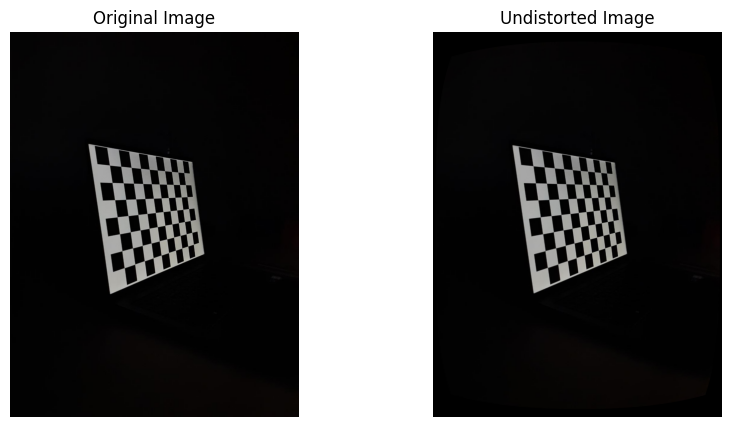

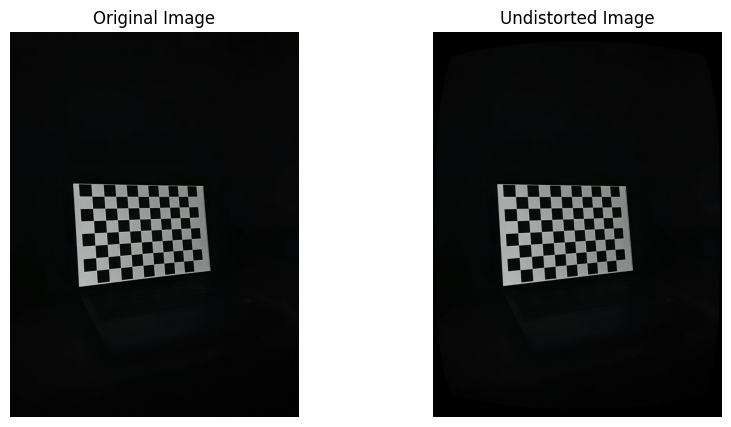

Ошибка:  0.02119280684767366


In [9]:
import cv2
import numpy as np
import glob

# Фотографии шахматной доски
images = glob.glob('./data/calibr_images/*.jpg')

# Найдем углы шахматной доски
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objpoints = []
imgpoints = []

objp = np.zeros((10*7, 3), np.float32)
objp[:, :2] = np.mgrid[0:10, 0:7].T.reshape(-1, 2)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # преобразуем изображение в бинарное
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(binary, (10, 7), None)

    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)
    else:
        print(f"Нет углов на изображении {fname}")

    # Вывод количества найденных точек на текущем изображении
    if corners is not None:
        print(f"Image {fname}: {len(corners)} углов найдено")

# Используем калибровочные данные для нахождения параметров камеры
ret, mtx, dist, rvecs, tvecs= cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Найденные параметры калибровки
print("Intrinsic matrix:")
print(mtx)
print("Distortion coefficients:")
print(dist)

for fname in images:
    img = cv2.imread(fname)
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Undistorted Image')
    axes[1].axis('off')

    plt.show()

# ошибка репроектирования
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error

print("Ошибка: ", mean_error / len(objpoints))